In [253]:
import pywt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from pmdarima.arima import auto_arima
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [175]:
Data = pd.read_csv('AMZN.csv', header=0, usecols=['Date', 'Close'], parse_dates=True, index_col='Date')
Data.index = pd.to_datetime(Data.index)

,Close
Date,
2000-06-05,54.5000
2000-06-06,50.5625
2000-06-07,51.8125
2000-06-08,51.8750
2000-06-09,52.1875


,Close
count,4529.000000
mean,243.952496
std,323.696425
min,5.970000
25%,38.740002
50%,87.269997
75%,306.540009
max,1696.349976


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4529 entries, 2000-06-05 to 2018-06-05
Data columns (total 1 columns):
Close    4529 non-null float64
dtypes: float64(1)
memory usage: 70.8 KB


None

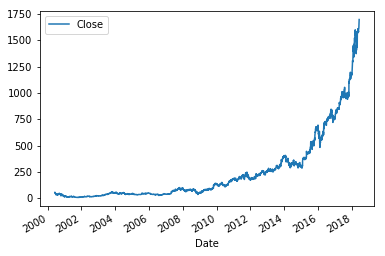

In [167]:
Data.plot()
display(Data.head())
display(Data.describe())
display(Data.info())

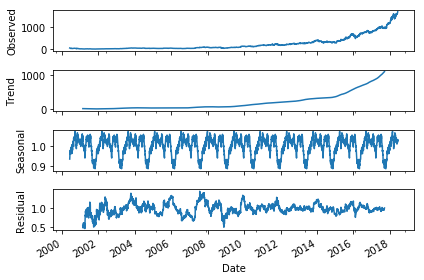

In [168]:
decomposition = seasonal_decompose(Data, model='multiplicative', freq=365)
decomposition.plot()
display(decomposition)

<Figure size 432x288 with 0 Axes>

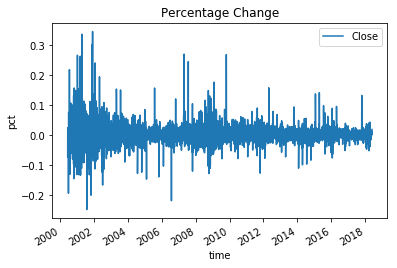

<Figure size 432x288 with 0 Axes>

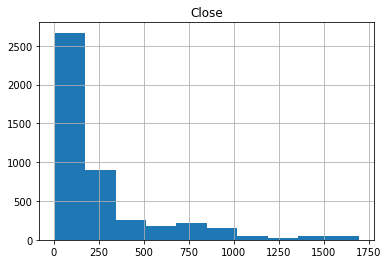

<Figure size 432x288 with 0 Axes>

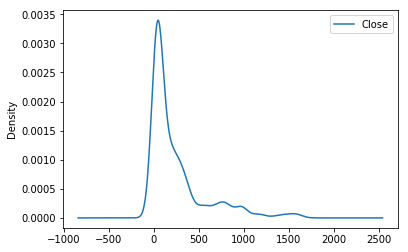

In [169]:
plt.figure()
pct_change.plot()
plt.title('Percentage Change')
plt.xlabel('time')
plt.ylabel('pct')
plt.show()

plt.figure()
Data.hist()
plt.show()


plt.figure()
Data.plot(kind='kde')
plt.show()

Tain test split

In [176]:
data_boxcox, lam = boxcox(Data['Close'])
print('lambda: ', lam)

data_len = len(data_boxcox)
data_boxcox_original = data_boxcox

TrainLen = int(data_len *.7)
TestLen = data_len - TrainLen
data_boxcox = data_boxcox_original[0:TrainLen:]
data_boxcox_test = data_boxcox_original[TrainLen:data_len:]


data_A, data_D = pywt.dwt(data_boxcox, 'db1') #C is low frequency signal, D is high frequency signal

lambda:  -0.05054507538198511


This is obviously non-stationary, so I'll apply a power transform. Specifically, I'll use boxcox

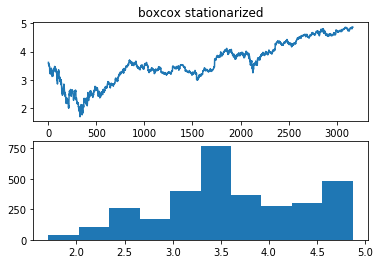

In [177]:
plt.figure(1)
# line plot
plt.subplot(211)
plt.title('boxcox stationarized')
plt.plot(data_boxcox)
# histogram
plt.subplot(212)
plt.hist(data_boxcox)
plt.show()#seems to be just a log power

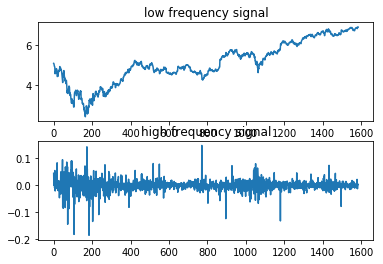

In [178]:
plt.figure(2)
plt.subplot(211)
plt.title('low frequency signal')
plt.plot(data_A)
plt.subplot(212)
plt.title('high frequency signal')
plt.plot(data_D)
plt.show()

low frequency


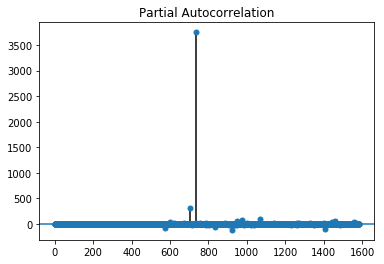

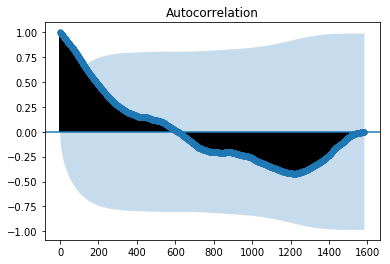

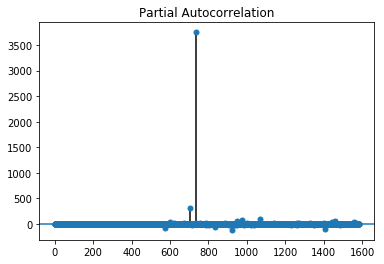

In [259]:
print('low frequency')
plot_acf(data_A)
plot_pacf(data_A)

high frequency


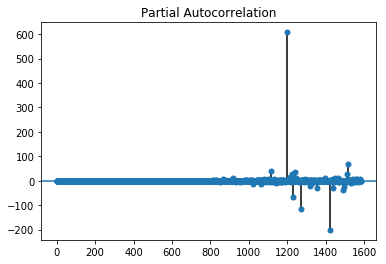

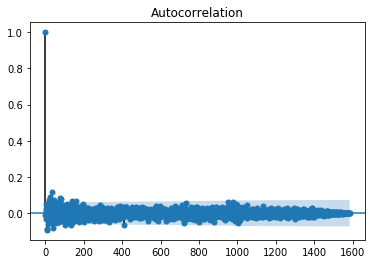

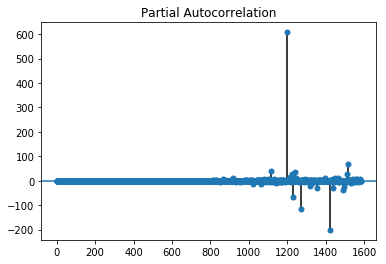

In [260]:
print('high frequency')
plot_acf(data_D)
plot_pacf(data_D)

Next is to perform an auto ARIMA on both low and high frequency signals. Aftwerwards, take the residuals of both and train on them with an ANN

In [244]:
stepwise_model_A = auto_arima(data_A, start_p=1, start_q=1,
                           max_p=10, max_q=10,max_d=10, m=30,
                           start_P=0, seasonal=True,
                           start_d=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_A.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 1, 30); AIC=-4797.618, BIC=-4770.780, Fit time=7.154 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 30); AIC=-4773.643, BIC=-4762.907, Fit time=0.369 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 0, 0, 30); AIC=-4799.225, BIC=-4777.754, Fit time=7.842 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 1, 30); AIC=-4799.611, BIC=-4778.141, Fit time=10.535 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 0, 1, 30); AIC=-4797.681, BIC=-4770.843, Fit time=7.217 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 30); AIC=-4801.396, BIC=-4785.293, Fit time=0.613 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 30); AIC=-4799.409, BIC=-4777.938, Fit time=0.576 seconds
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 0, 0, 30); AIC=-4799.409, BIC=-4777.938, Fit time=0.967 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 0, 0, 30); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1,

In [245]:
stepwise_model_D = auto_arima(data_D, start_p=1, start_q=1, start_d=1,
                           max_p=10, max_q=10, max_d=10, m=30,
                           start_P=0, seasonal=True, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model_D.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 30); AIC=-7521.223, BIC=-7494.381, Fit time=11.797 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 30); AIC=-7526.320, BIC=-7515.584, Fit time=0.256 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 30); AIC=-7523.471, BIC=-7501.998, Fit time=2.530 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 30); AIC=-7523.442, BIC=-7501.969, Fit time=9.561 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 30); AIC=-7525.235, BIC=-7509.130, Fit time=3.460 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 30); AIC=-7525.196, BIC=-7509.091, Fit time=8.557 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 30); AIC=-7523.212, BIC=-7501.738, Fit time=5.758 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 30); AIC=-7524.533, BIC=-7508.428, Fit time=0.186 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 30); AIC=-7524.514, BIC=-7508.409, Fit time=0.541 seconds
Fit ARIMA

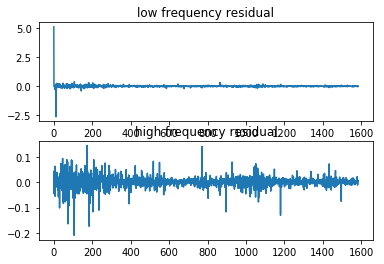

In [181]:
residuals_A = stepwise_model_A.resid()
residuals_D = stepwise_model_D.resid()

plt.figure(3)
plt.subplot(211)
plt.title('low frequency residual')
plt.plot(residuals_A)
plt.subplot(212)
plt.title('high frequency residual')
plt.plot(residuals_D)
plt.show()

In [186]:
def DatasetCreation(dataset, TimeStep=1):
    DataX, DataY = [], []
    for i in range(len(dataset) - TimeStep -1):
        a = dataset[i:(i+TimeStep), 0]
        DataX.append(a)
        DataY.append(dataset[i+TimeStep,0])
    return np.array(DataX), np.array(DataY)

def DatasetCreation_Test(dataset, TimeStep=1):
    DataX = []
    for i in range(len(dataset) - TimeStep -1):
        a = dataset[i:(i+TimeStep), 0]
        DataX.append(a)
    return np.array(DataX)

In [201]:
scaler_A = MinMaxScaler()
scaler_D = MinMaxScaler()

scaler_A.fit(residuals_A.reshape(-1, 1))
scaler_D.fit(residuals_D.reshape(-1, 1))

data_scaled_resid_A = scaler_A.transform(residuals_A.reshape(-1, 1))
data_scaled_resid_D = scaler_D.transform(residuals_D.reshape(-1, 1))

In [83]:
def get_lstm(TimeStep):
    model = Sequential()
    model.add(LSTM(256, input_shape=(1,TimeStep)))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['accuracy'])
    return model
TimeStep = 1
lstm_resid_A = get_lstm(TimeStep)
lstm_resid_D = get_lstm(TimeStep)

Instructions for updating:
Colocations handled automatically by placer.


In [102]:
TrainX_A, TrainY_A = DatasetCreation(data_scaled_resid_A, TimeStep)
TrainX_D, TrainY_D = DatasetCreation(data_scaled_resid_D, TimeStep)

TrainX_A = np.reshape(TrainX_A, (TrainX_A.shape[0], 1, TrainX_A.shape[1]))
TrainX_D = np.reshape(TrainX_A, (TrainX_A.shape[0], 1, TrainX_A.shape[1]))

array([[[1.        ]],

       [[0.33734847]],

       [[0.33458866]],

       ...,

       [[0.34065602]],

       [[0.33908011]],

       [[0.34008242]]])

In [104]:
lstm_resid_A.fit(TrainX_A, TrainY_A, epochs=100, batch_size=1, verbose=1)

Instructions for updating:
Use tf.cast instead.
Epoch 1/100
2263/2263 [==============================] - 22s 10ms/step - loss: 3.7053e-04 - acc: 4.4189e-04
Epoch 2/100
2263/2263 [==============================] - 21s 9ms/step - loss: 1.0470e-04 - acc: 4.4189e-04
Epoch 3/100
2263/2263 [==============================] - 21s 9ms/step - loss: 1.0714e-04 - acc: 4.4189e-04
Epoch 4/100
2263/2263 [==============================] - 21s 9ms/step - loss: 1.0583e-04 - acc: 4.4189e-04
Epoch 5/100
2263/2263 [==============================] - 21s 9ms/step - loss: 1.0537e-04 - acc: 4.4189e-04
Epoch 6/100
2263/2263 [==============================] - 23s 10ms/step - loss: 1.0315e-04 - acc: 4.4189e-04
Epoch 7/100
2263/2263 [==============================] - 25s 11ms/step - loss: 1.0305e-04 - acc: 4.4189e-04
Epoch 8/100
2263/2263 [==============================] - 25s 11ms/step - loss: 1.0159e-04 - acc: 4.4189e-04
Epoch 9/100
2263/2263 [==============================] - 24s 11ms/step - loss: 1.0165e-04 - 

2263/2263 [==============================] - 22s 10ms/step - loss: 9.4296e-05 - acc: 4.4189e-04
Epoch 75/100
2263/2263 [==============================] - 22s 10ms/step - loss: 9.4427e-05 - acc: 4.4189e-04
Epoch 76/100
2263/2263 [==============================] - 22s 10ms/step - loss: 9.4557e-05 - acc: 4.4189e-04
Epoch 77/100
2263/2263 [==============================] - 21s 9ms/step - loss: 9.3330e-05 - acc: 4.4189e-04
Epoch 78/100
2263/2263 [==============================] - 21s 9ms/step - loss: 9.3081e-05 - acc: 4.4189e-04
Epoch 79/100
2263/2263 [==============================] - 21s 9ms/step - loss: 9.3974e-05 - acc: 4.4189e-04
Epoch 80/100
2263/2263 [==============================] - 21s 9ms/step - loss: 9.3423e-05 - acc: 4.4189e-04
Epoch 81/100
2263/2263 [==============================] - 21s 9ms/step - loss: 9.3147e-05 - acc: 4.4189e-04
Epoch 82/100
2263/2263 [==============================] - 21s 9ms/step - loss: 9.3672e-05 - acc: 4.4189e-04
Epoch 83/100
2263/2263 [==============

In [106]:
lstm_resid_D.fit(TrainX_D, TrainY_D, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
2263/2263 [==============================] - 21s 9ms/step - loss: 0.0035 - acc: 4.4189e-04
Epoch 2/100
2263/2263 [==============================] - 20s 9ms/step - loss: 0.0034 - acc: 4.4189e-04
Epoch 3/100
2263/2263 [==============================] - 20s 9ms/step - loss: 0.0034 - acc: 4.4189e-04
Epoch 4/100
2263/2263 [==============================] - 20s 9ms/step - loss: 0.0034 - acc: 4.4189e-04
Epoch 5/100
2263/2263 [==============================] - 20s 9ms/step - loss: 0.0034 - acc: 4.4189e-04
Epoch 6/100
2263/2263 [==============================] - 21s 9ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 7/100
2263/2263 [==============================] - 20s 9ms/step - loss: 0.0034 - acc: 4.4189e-04
Epoch 8/100
2263/2263 [==============================] - 20s 9ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 9/100
2263/2263 [==============================] - 20s 9ms/step - loss: 0.0034 - acc: 4.4189e-04
Epoch 10/100
2263/2263 [==============================] - 20s 9ms/step - 

2263/2263 [==============================] - 14s 6ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 80/100
2263/2263 [==============================] - 14s 6ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 81/100
2263/2263 [==============================] - 14s 6ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 82/100
2263/2263 [==============================] - 14s 6ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 83/100
2263/2263 [==============================] - 14s 6ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 84/100
2263/2263 [==============================] - 14s 6ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 85/100
2263/2263 [==============================] - 14s 6ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 86/100
2263/2263 [==============================] - 14s 6ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 87/100
2263/2263 [==============================] - 14s 6ms/step - loss: 0.0033 - acc: 4.4189e-04
Epoch 88/100
2263/2263 [==============================] - 14s 6ms/step - loss

In the last stage, combine residual predictions, and ARIMA predictions for high and low frequency signals to receive the ultimate prediction. Be sure to descale the data from the residuals. Compare to validation set.

In [204]:
TestX_A = DatasetCreation_Test(scaler_A.transform(data_boxcox_test.reshape(-1, 1)), TimeStep)
TestX_A = np.reshape(TestX_A, (TestX_A.shape[0], 1, TestX_A.shape[1]))

TestX_D= DatasetCreation_Test(scaler_D.transform(data_boxcox_test.reshape(-1, 1)), TimeStep)
TestX_D = np.reshape(TestX_D, (TestX_D.shape[0], 1, TestX_D.shape[1]))

In [239]:
forecast_periods = 2263

pred_res_A = scaler_A.inverse_transform(lstm_resid_A.predict(TrainX_A)).flatten()
arima_pred_A = stepwise_model_A.predict(n_periods=forecast_periods)

pred_res_D = scaler_D.inverse_transform(lstm_resid_D.predict(TrainX_D)).flatten()
arima_pred_D = stepwise_model_D.predict(n_periods=forecast_periods)

signal_A = arima_pred_A + pred_res_A
signal_D = arima_pred_D + pred_res_D

forecast = pywt.idwt(signal_A, signal_D, 'db2')
forecast = inv_boxcox(forecast, lam)

In [254]:
ff1 = pywt.idwt(stepwise_model_A.predict(n_periods=forecast_periods), stepwise_model_D.predict(n_periods=forecast_periods), 'db1')
ff1 = inv_boxcox(ff1, lam)

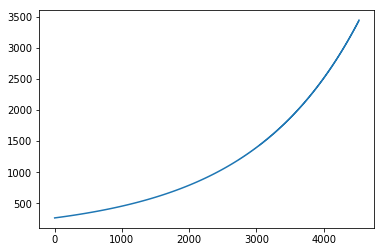

In [255]:
plt.plot(ff1)

<Figure size 432x288 with 0 Axes>

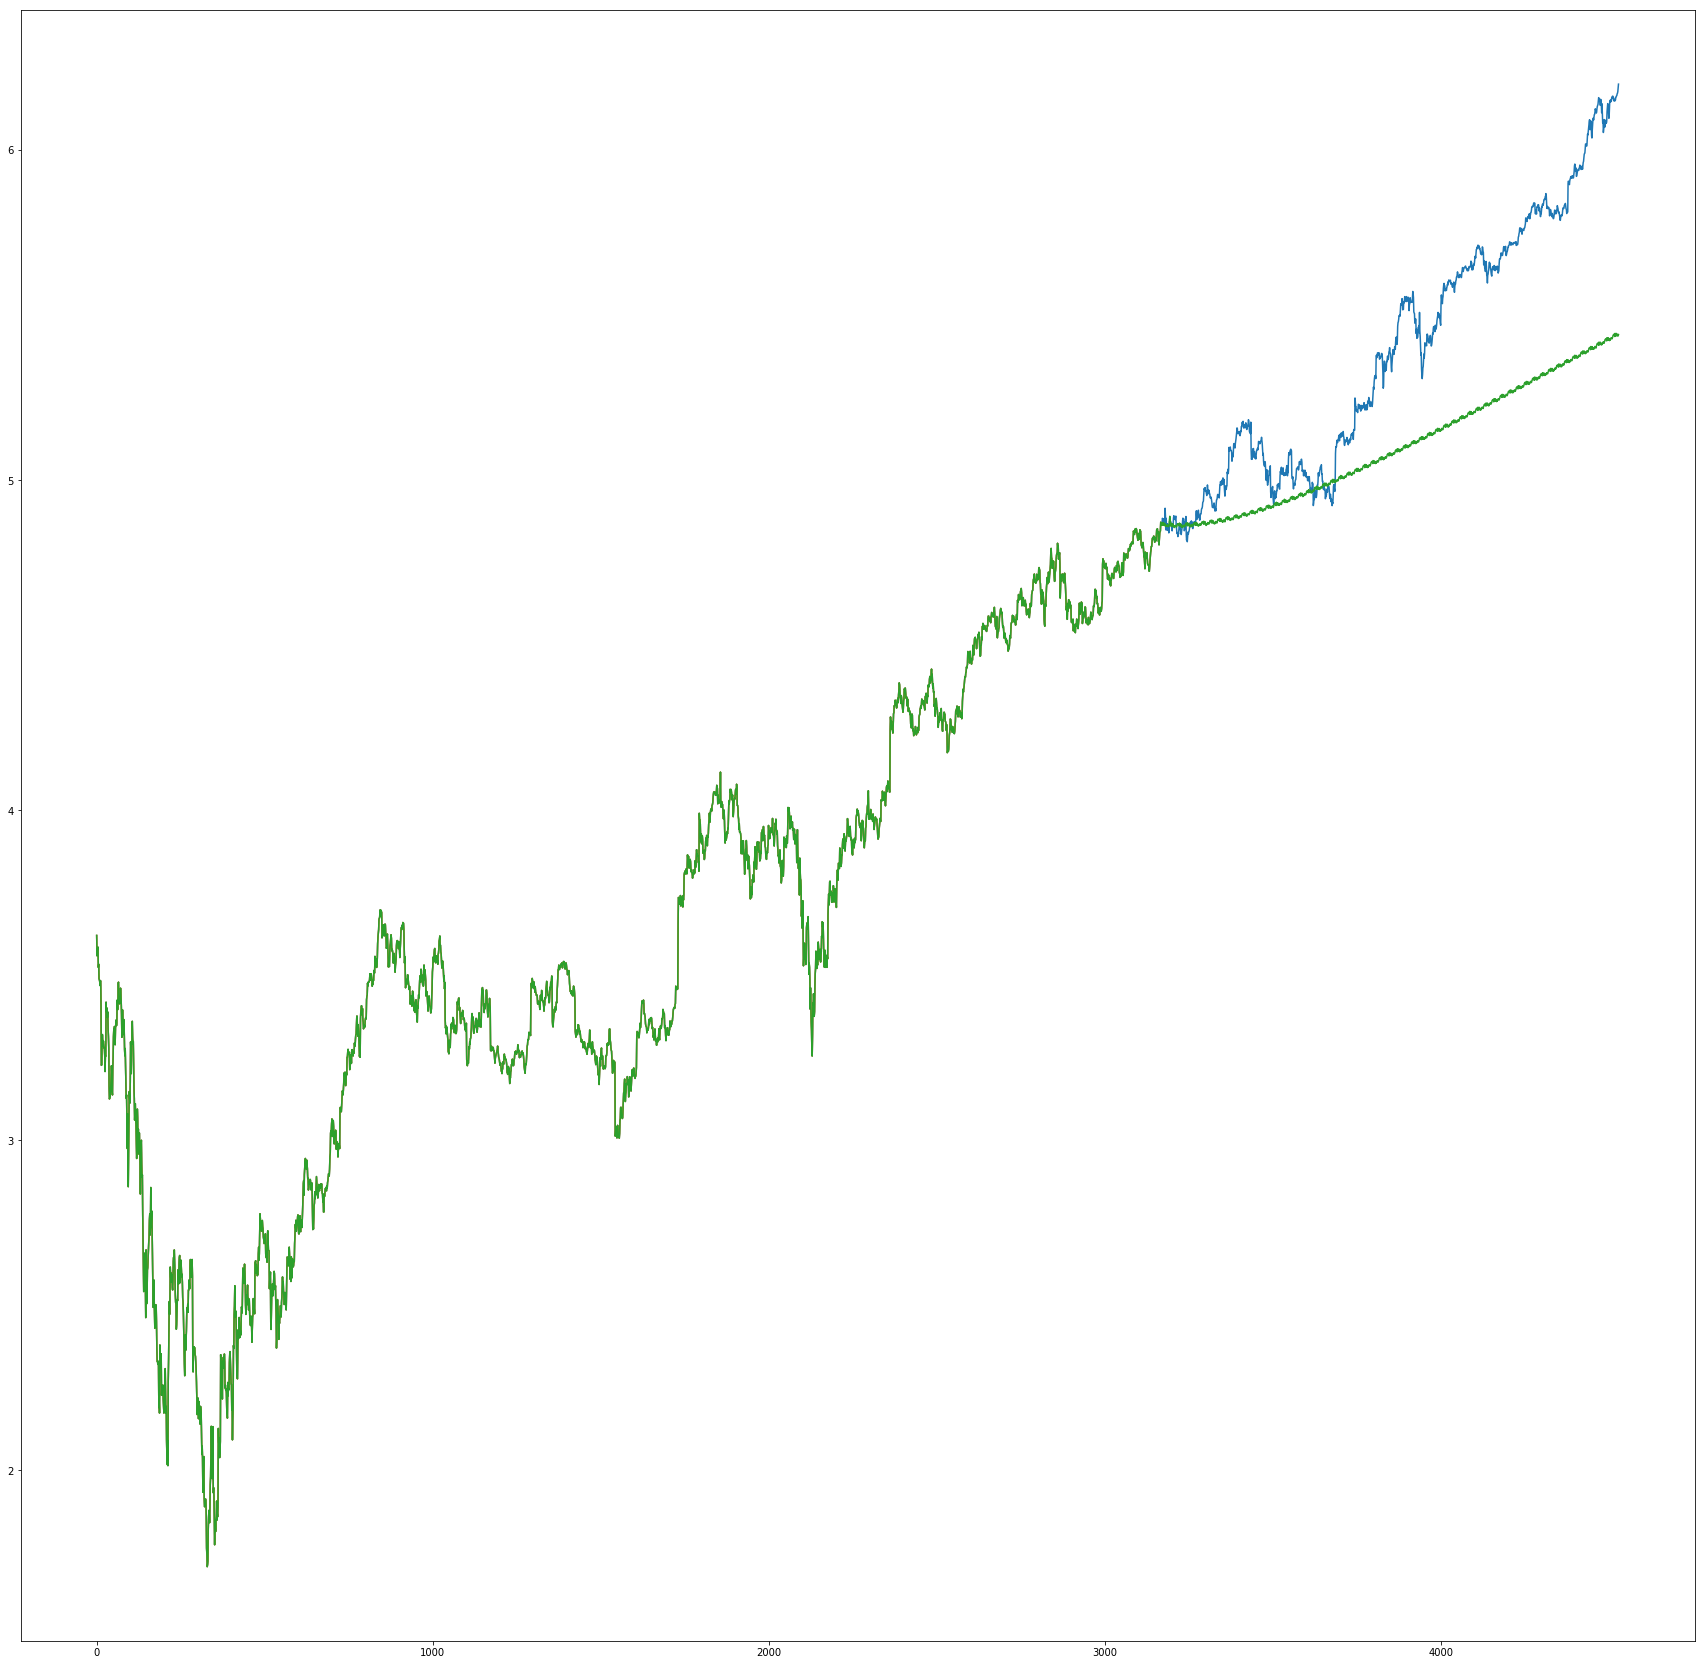

In [256]:
fore = np.concatenate((data_boxcox, forecast[0:TestLen,]), axis=None)
plt.figure(4)

plt.figure(figsize=(30,30))
plt.plot(data_boxcox_original)
plt.plot(data_boxcox)
plt.plot(fore)
plt.show()